In [40]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
# import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Block, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

from scipy.interpolate import interp1d

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo_fixed_3or4_layers import ODEOptimizationModel
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel_flexible
from pickle_func import pickle_data, unpickle_data

In [41]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [3]:
ode_model = ODEOptimizationModel(y_noisy, t, D, [3, 10, 10, 2], penalty_lambda = 1000, max_iter = 200)
ode_model.build_model()
ode_model.solve_model(True)

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    u, v = y
    du_dt, dv_dt = ode_model.predict(t, u, v)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
solution = odeint(system_dynamics, initial_conditions, t)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

Ipopt 3.14.16: max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    51876
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    69234

Total number of variables............................:      372
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      198

In [7]:
print(ode_model.mae(y, u_model, v_model))
print(ode_model.mae(y, u_odeint, v_odeint))

0.15893423953213492
0.21643096218041524


In [4]:
"""pred = {
    't': t,
    'odeint_solution': solution,
    'u_model': u_model,
    'v_model': v_model,
    'y': y,
    'y_noisy': y_noisy
}

pickle_data(pred, 'harmonic_oscillator_pred_3_10_10_2.pkl')"""
data = unpickle_data('harmonic_oscillator_pred_3_10_10_2.pkl')

Data successfully unpickled from harmonic_oscillator_pred_3_10_10_2.pkl


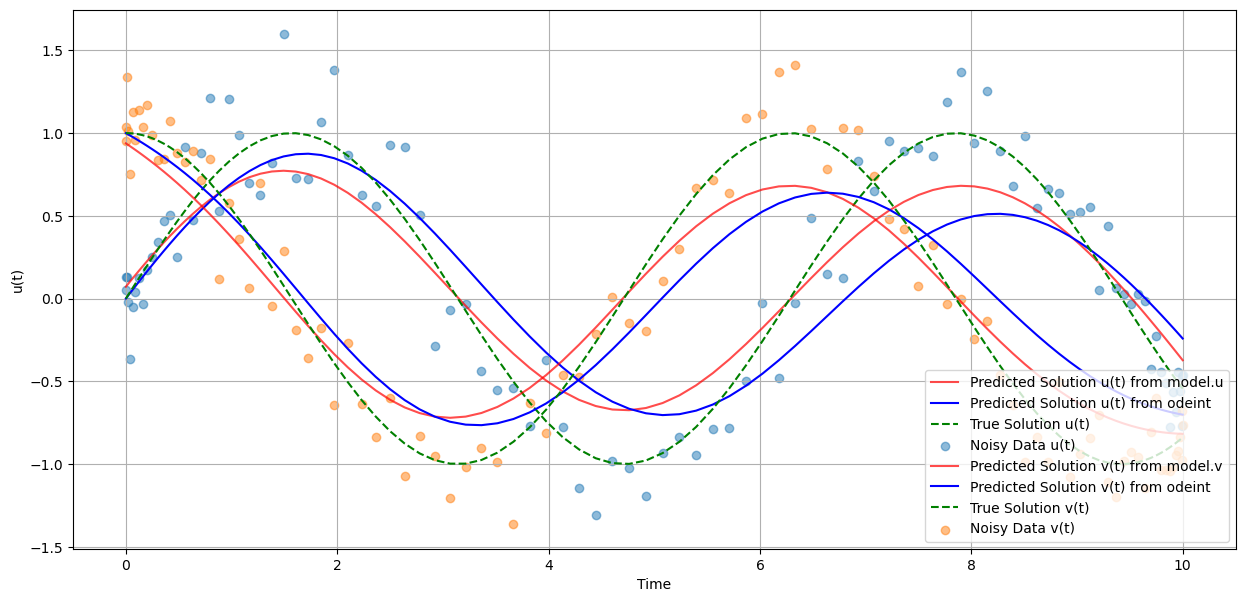

In [5]:
t_temp, odeint_solution_temp, u_model_temp, v_model_temp, y_noisy_temp, y_temp = data["t"], data["odeint_solution"], data["u_model"], data["v_model"], data["y_noisy"], data["y"]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_temp, u_model_temp, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_temp, odeint_solution_temp.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_temp, y_temp.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t_temp, y_noisy_temp.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_temp, v_model_temp, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_temp, odeint_solution_temp.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_temp, y_temp.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t_temp, y_noisy_temp.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [38]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 150
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [39]:
ode_model = ODEOptimizationModel(y_noisy, t, D, [3, 50, 2], penalty_lambda = 1000, max_iter = 200)
ode_model.build_model()
ode_model.solve_model(True)

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    u, v = y
    du_dt, dv_dt = ode_model.predict(t, u, v)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
solution = odeint(system_dynamics, initial_conditions, t)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

Ipopt 3.14.16: max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   119796
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   178799

Total number of variables............................:      602
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      298

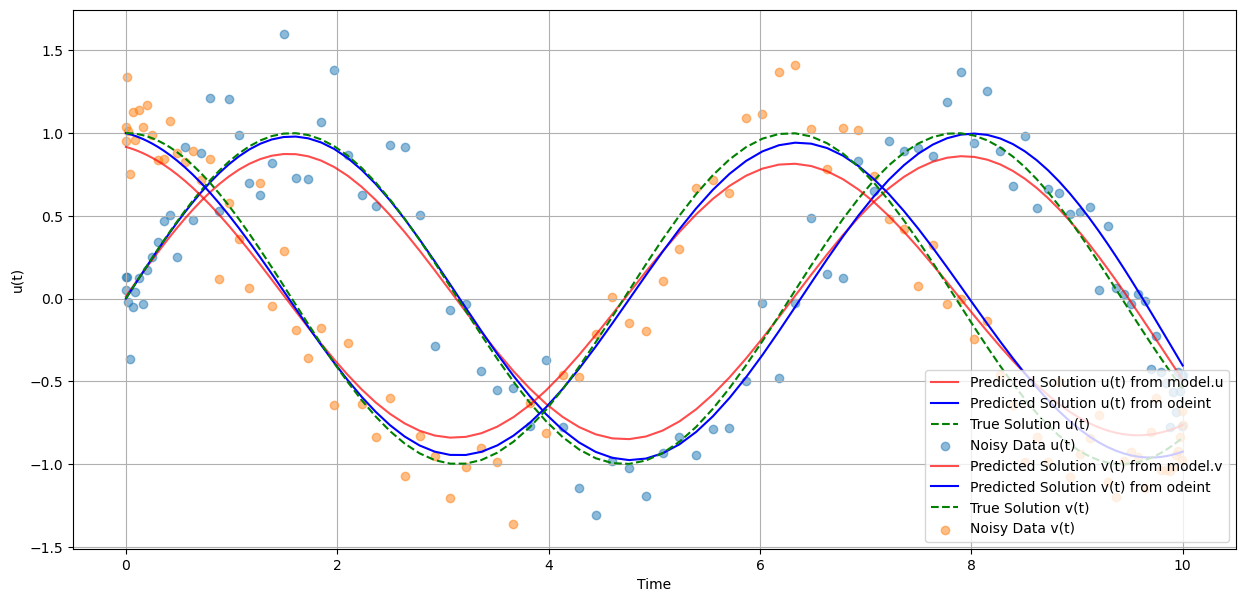

In [9]:
print(ode_model.mae(y, u_model, v_model))
print(ode_model.mae(y, u_odeint, v_odeint))

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, solution.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, solution.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

#### Optimize `N of points` and `N of neurons in the hidden layer`

In [42]:
n_pts_li = [25, 50, 100, 150, 200, 300, 500]
n_neurons_li = [10, 50, 100]

In [43]:
results = {}
iter = 0
total_itel = len(n_pts_li) * len(n_neurons_li)

for n_pt in n_pts_li:
    
    # for each n_pts, generate data
    #---------------------------------------------DATA PARAMS---------------------------------------------#
    noise_level = 0.2
    ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
    start_time, end_time = 0, 10
    spacing_type = "chebyshev"
    initial_state = jnp.array([0.0, 1.0])

    #--------------------------------------------GENERATE DATA--------------------------------------------#
    t, y, y_noisy, true_derivatives = generate_ode_data(n_pt, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

    # numpy array is required for pyomo
    y_noisy = np.array(jnp.squeeze(y_noisy))
    t = np.array(jnp.squeeze(t))

    #---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
    weights = compute_weights(t)
    D = np.array(lagrange_derivative(t, weights))
    
    for n_neurons in n_neurons_li:
        print ("Iteration: ", iter, " out of ", total_itel)
        iter += 1
        #---------------------------------MODEL---------------------------------#
        time_1 = time.time()
        ode_model = ODEOptimizationModel(y_noisy, t, D, [3, n_neurons, 2], penalty_lambda = 1000, max_iter = 500)
        ode_model.build_model()
        ode_model.solve_model(True)
        time_2 = time.time()
        
        u_model, v_model = ode_model.extract_solution()

        def system_dynamics(y, t):
            u, v = y
            du_dt, dv_dt = ode_model.predict(t, u, v)
            return jnp.array([du_dt, dv_dt])

        initial_conditions = jnp.array([0.0, 1.0]) 
        solution = odeint(system_dynamics, initial_conditions, t)
        u_odeint, v_odeint = solution[:, 0], solution[:, 1]

        #---------------------------MEAN ABSOLUTE ERROR--------------------------#
        mae_model = ode_model.mae(y, u_model, v_model)
        mae_odeint = ode_model.mae(y, u_odeint, v_odeint)
        
        # save results
        results[str(n_pt) + "_" + str(n_neurons)] = {
            "t":t, "y":y, "y_noisy":y_noisy, 
            "mae_model":mae_model, "mae_odeint":mae_odeint, 
            "u_model":u_model, "v_model":v_model, 
            "u_odeint":u_odeint, "v_odeint":v_odeint,
            "solution":solution, "elapsed_time":time_2 - time_1,
            "n_pts":n_pt, "n_neurons":n_neurons
            }

Ipopt 3.14.16: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     3696
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6184

Total number of variables............................:      112
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       48

KeyboardInterrupt: 

In [20]:
# pickle_data(results, 'n_pts_neurons_hyperparam.pkl')
results = unpickle_data('n_pts_neurons_hyperparam.pkl')

Data successfully unpickled from n_pts_neurons_hyperparam.pkl


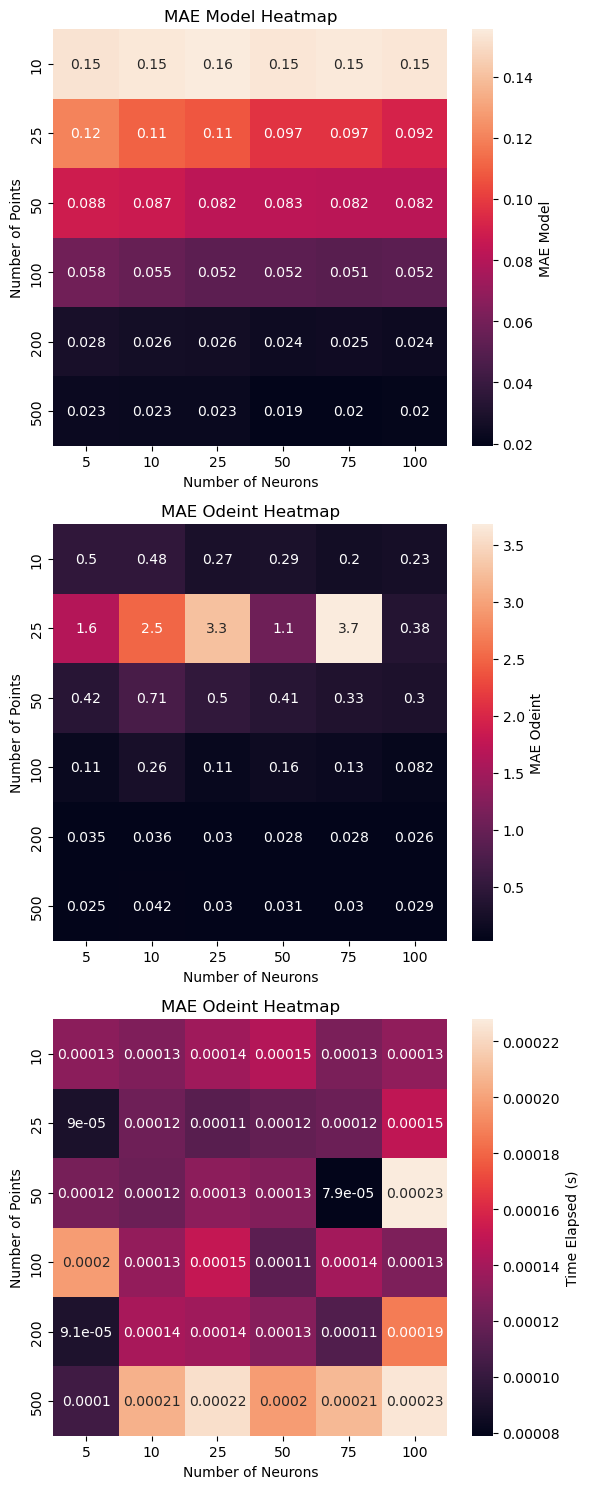

In [32]:
import seaborn as sns

# prepare data for heatmap
mae_model_matrix = np.zeros((len(n_pts_li), len(n_neurons_li)))
mae_odeint_matrix = np.zeros((len(n_pts_li), len(n_neurons_li)))
time_elapsed_matrix = np.zeros((len(n_pts_li), len(n_neurons_li)))

# number of points = rows, number of neurons = columns
for i, n_pt in enumerate(n_pts_li):
    for j, n_neurons in enumerate(n_neurons_li):
        key = f"{n_pt}_{n_neurons}"
        mae_model_matrix[i, j] = results[key]['mae_model']
        mae_odeint_matrix[i, j] = results[key]['mae_odeint']
        time_elapsed_matrix[i, j] = results[key]['elapsed_time']

# Plotting the heatmaps
fig, ax = plt.subplots(3, 1, figsize=(6, 15))

sns.heatmap(mae_model_matrix, annot=True, ax=ax[0], cbar_kws={'label': 'MAE Model'})
ax[0].set_title('MAE Model Heatmap')
ax[0].set_xlabel('Number of Neurons')
ax[0].set_ylabel('Number of Points')
ax[0].set_xticklabels(n_neurons_li)
ax[0].set_yticklabels(n_pts_li)

sns.heatmap(mae_odeint_matrix, annot=True, ax=ax[1], cbar_kws={'label': 'MAE Odeint'})
ax[1].set_title('MAE Odeint Heatmap')
ax[1].set_xlabel('Number of Neurons')
ax[1].set_ylabel('Number of Points')
ax[1].set_xticklabels(n_neurons_li)
ax[1].set_yticklabels(n_pts_li)

sns.heatmap(time_elapsed_matrix, annot=True, ax=ax[2], cbar_kws={'label': 'Time Elapsed (s)'})
ax[2].set_title('MAE Odeint Heatmap')
ax[2].set_xlabel('Number of Neurons')
ax[2].set_ylabel('Number of Points')
ax[2].set_xticklabels(n_neurons_li)
ax[2].set_yticklabels(n_pts_li)

plt.tight_layout()
plt.show()

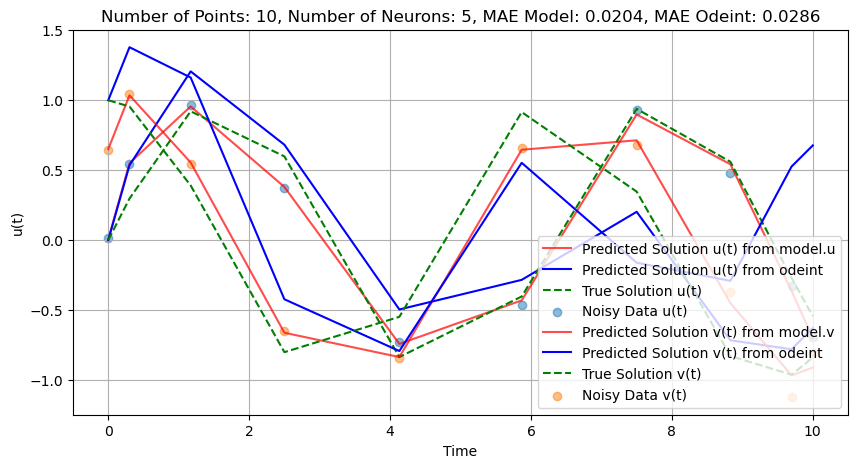

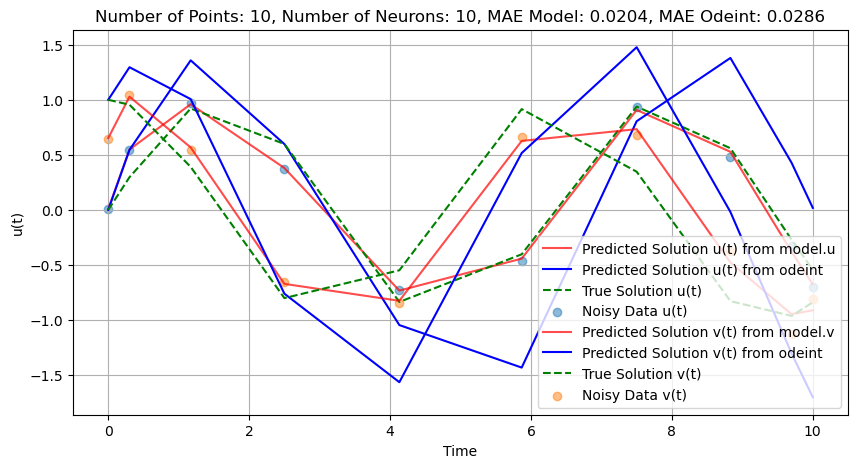

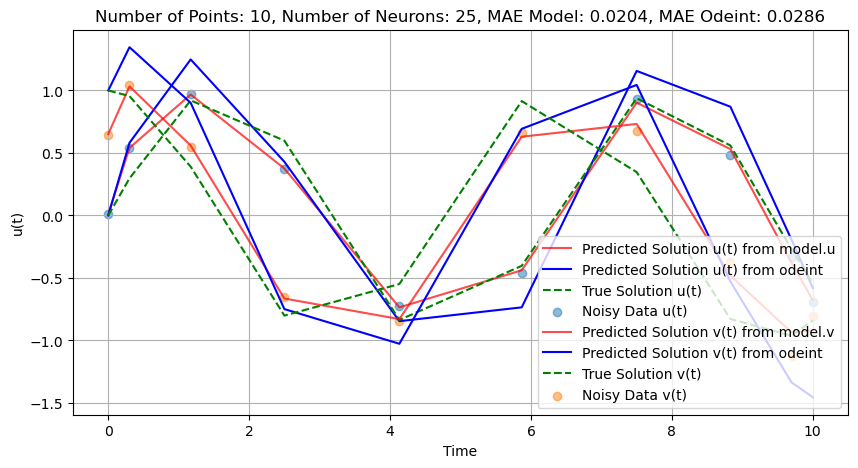

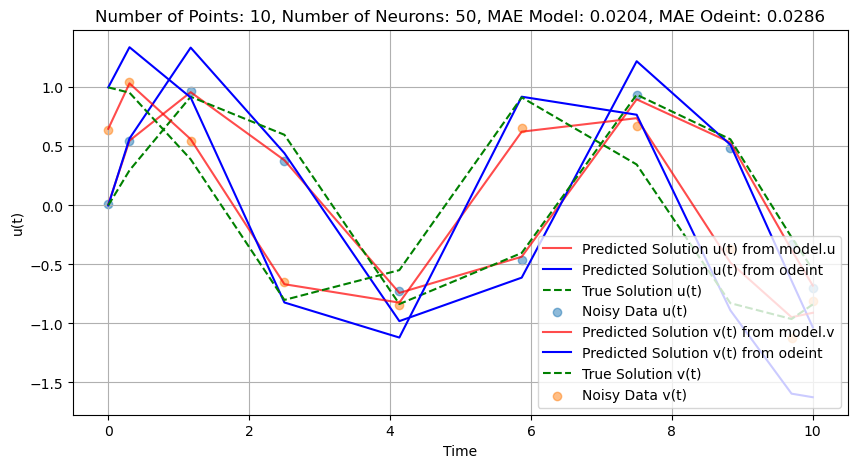

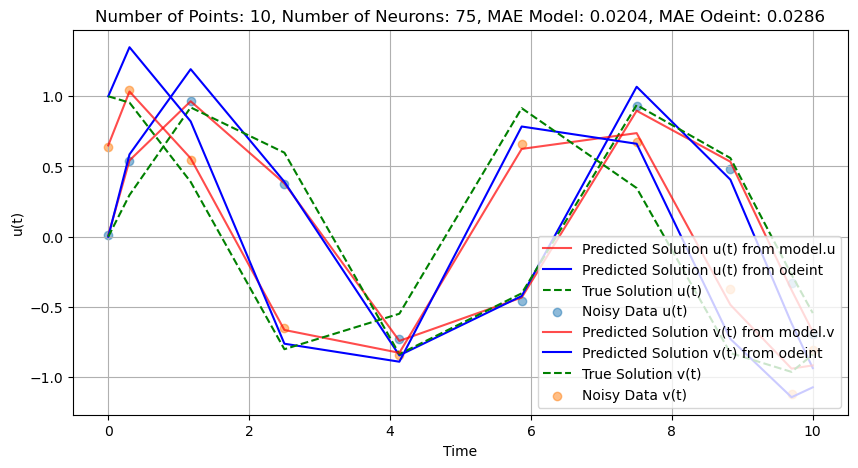

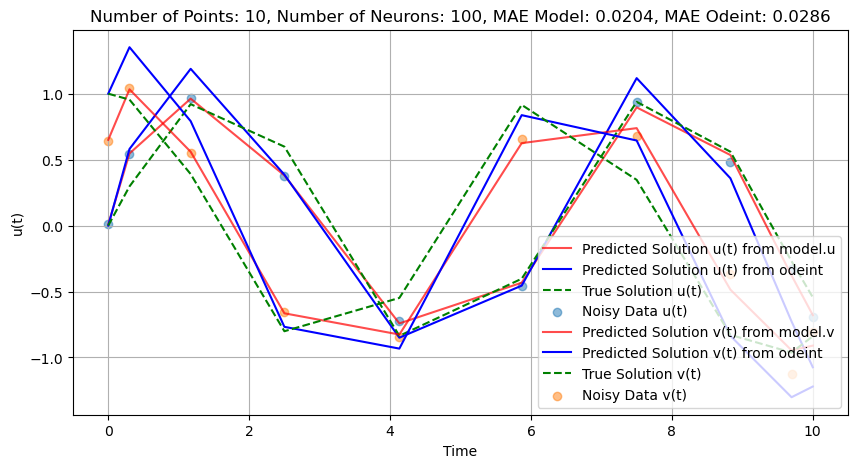

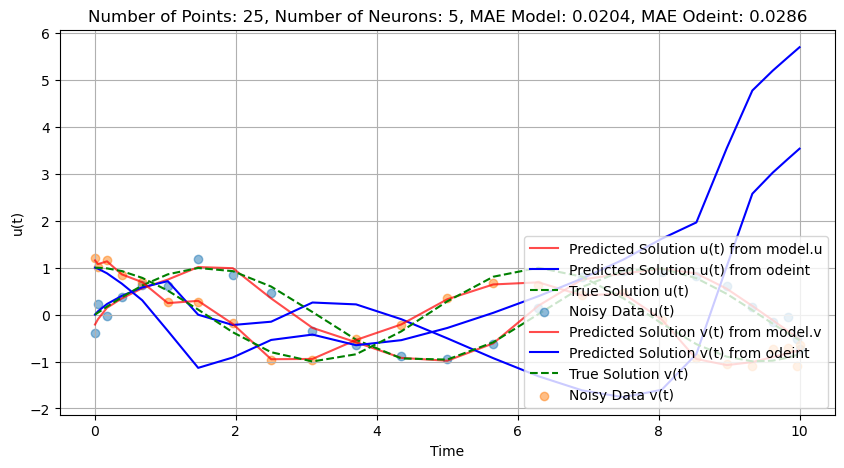

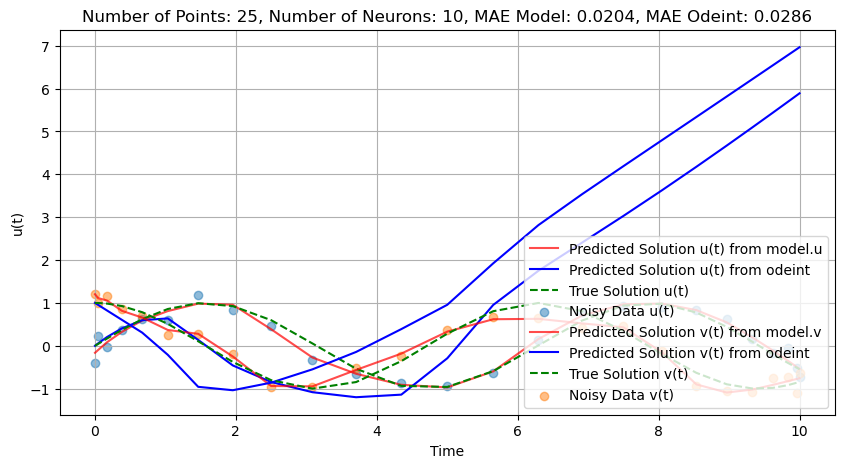

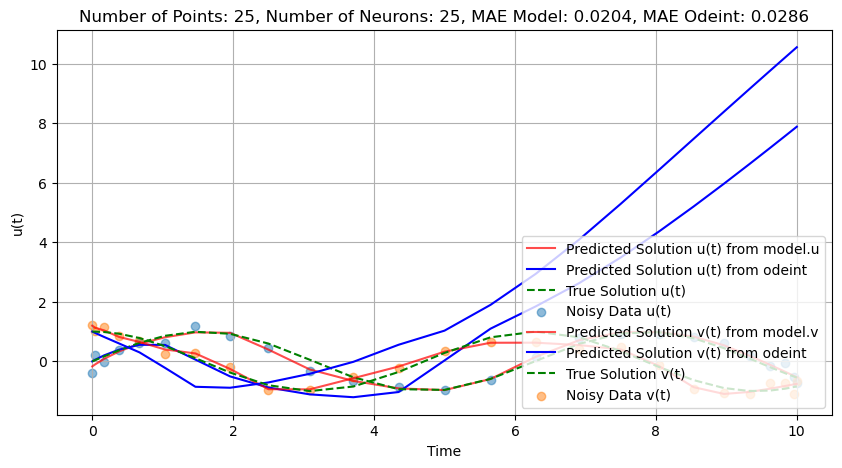

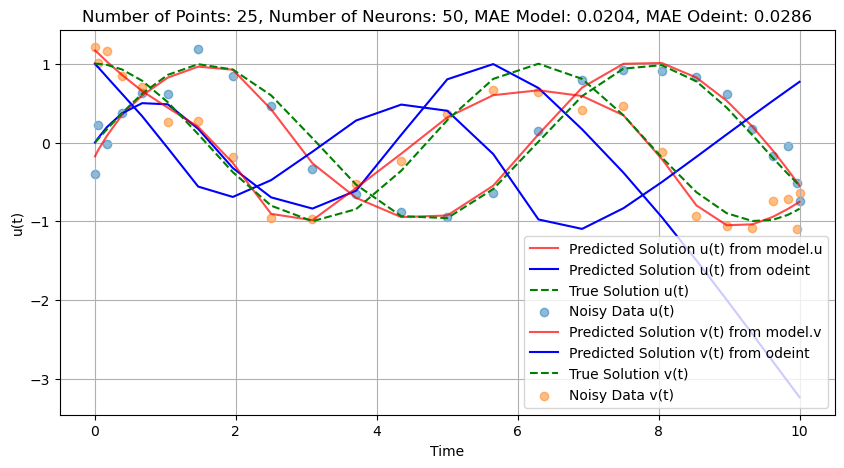

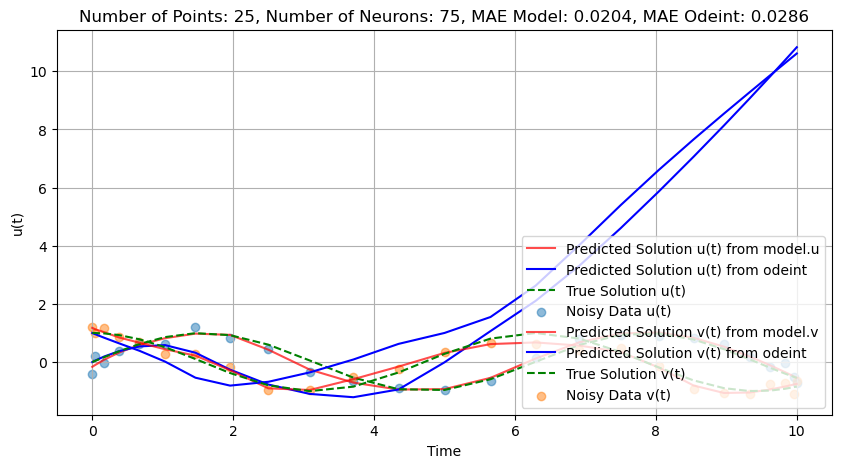

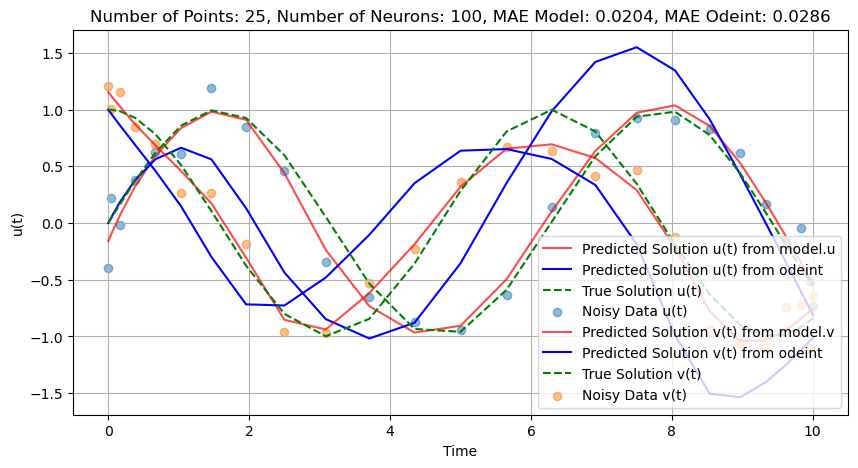

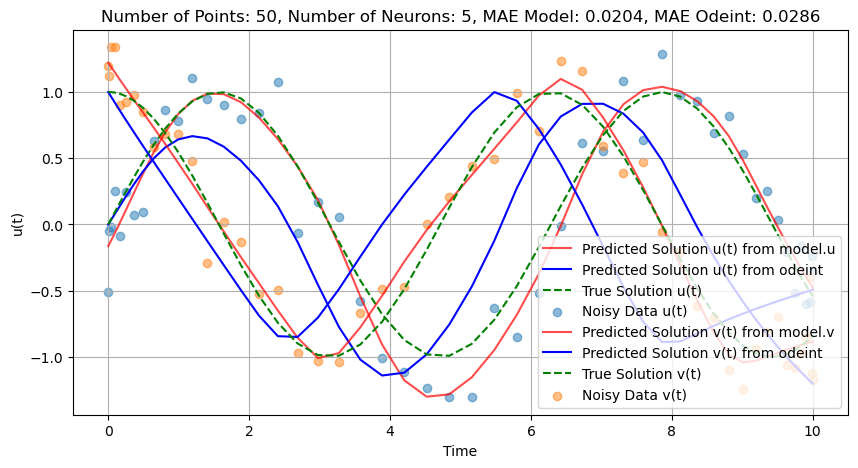

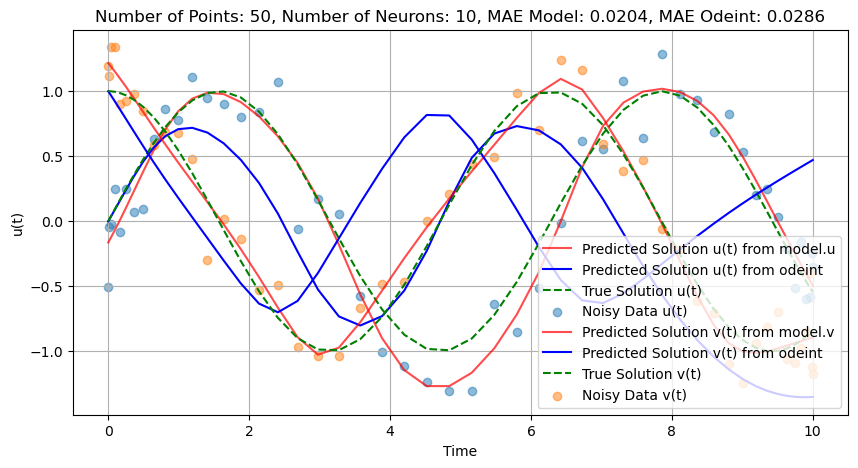

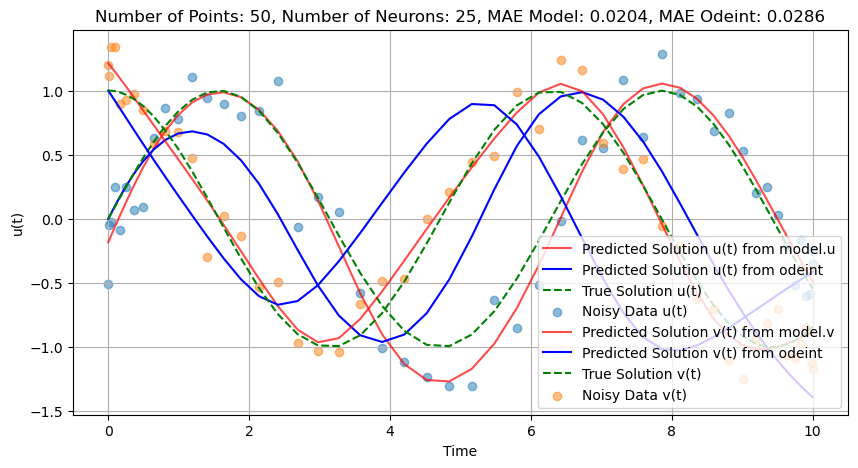

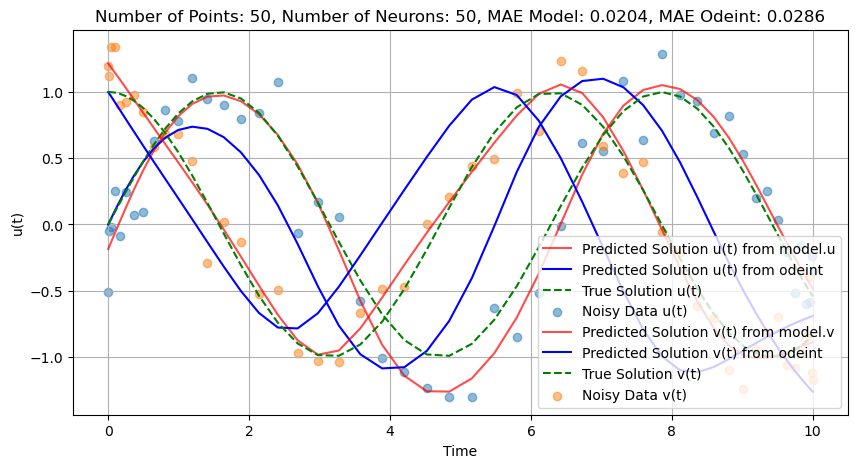

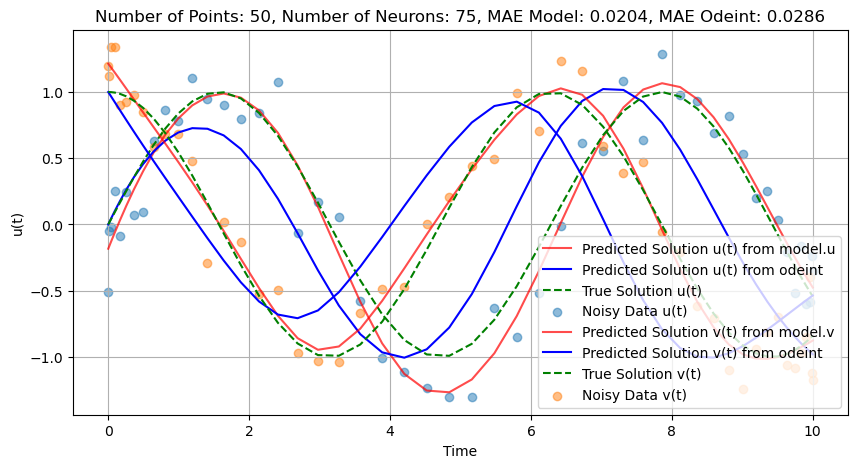

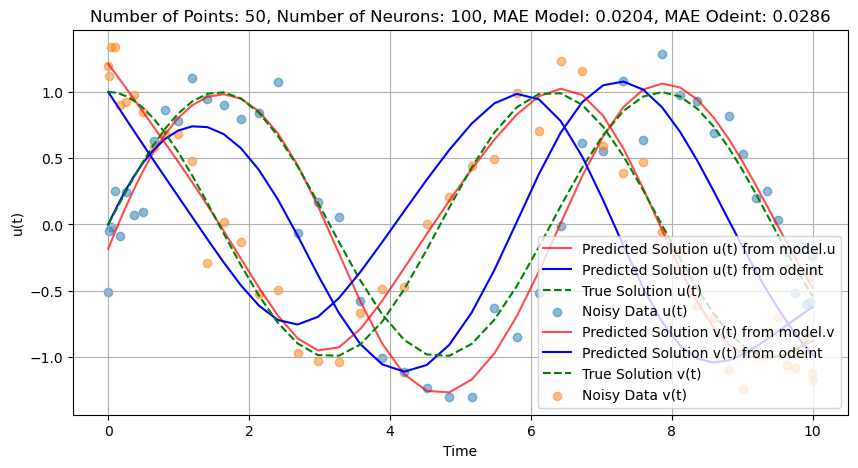

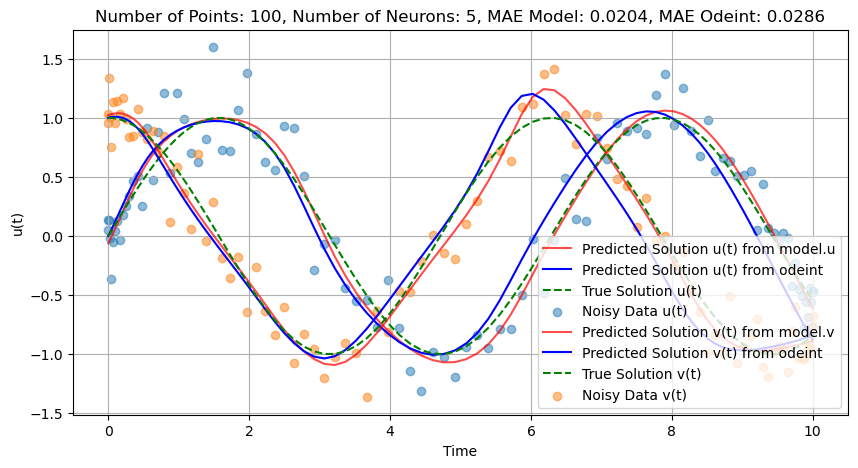

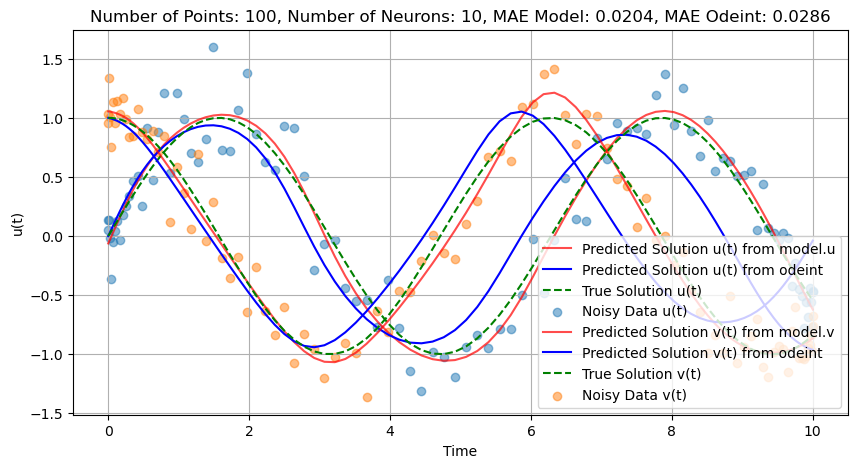

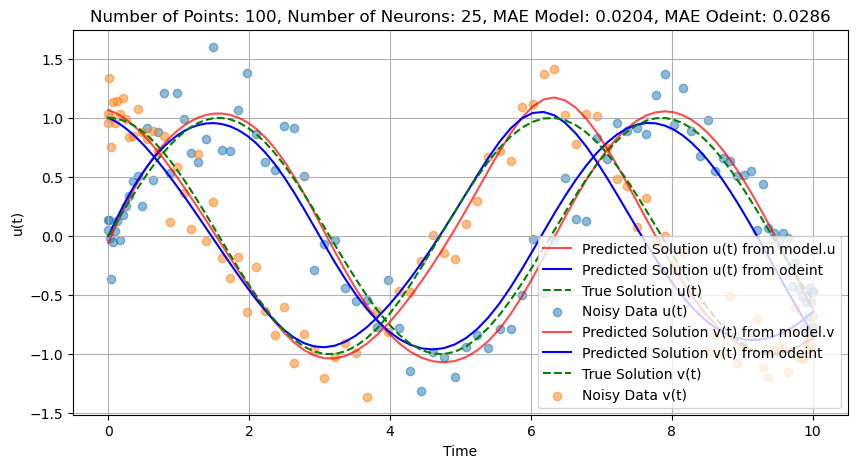

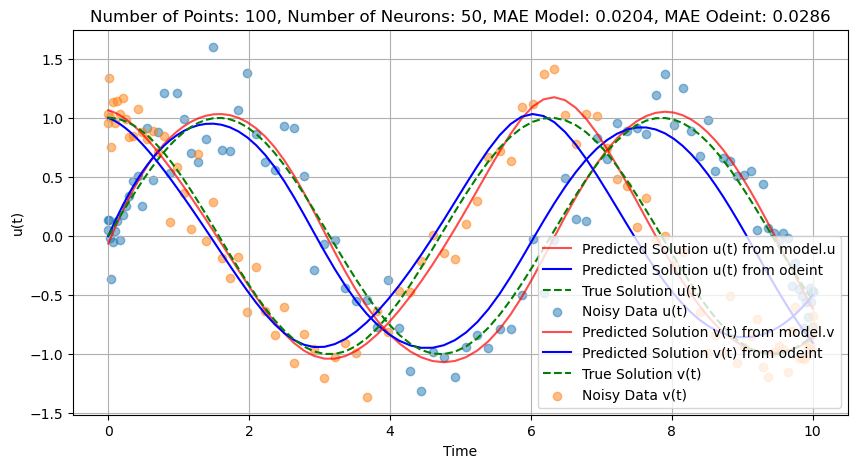

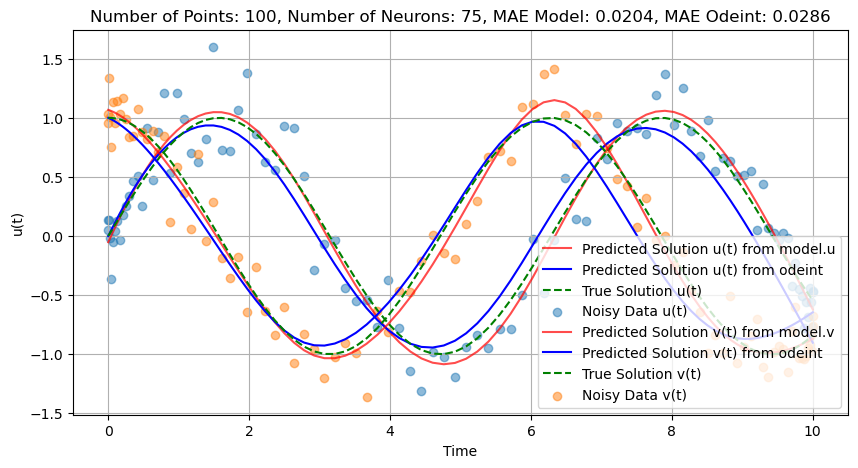

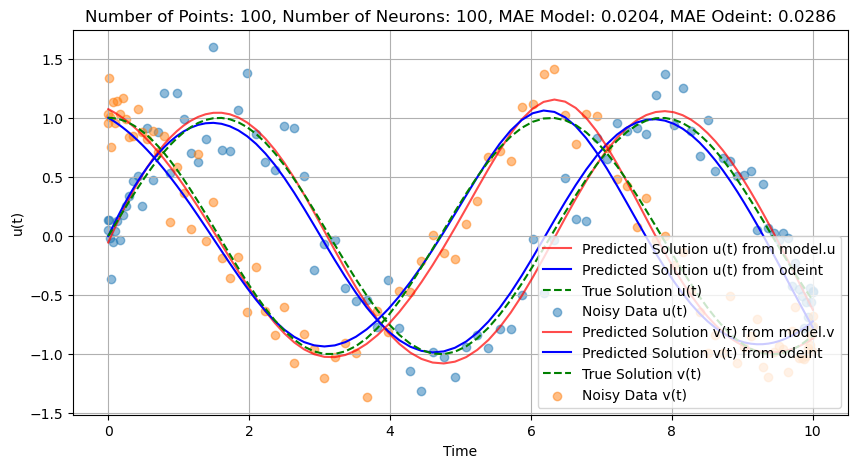

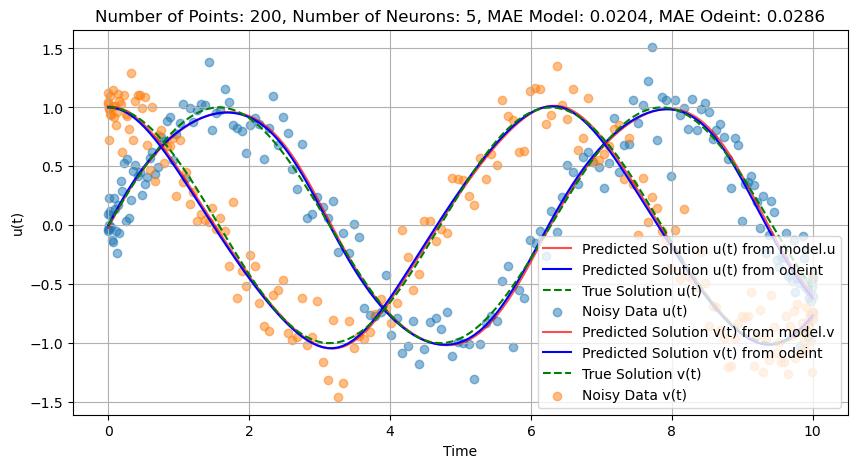

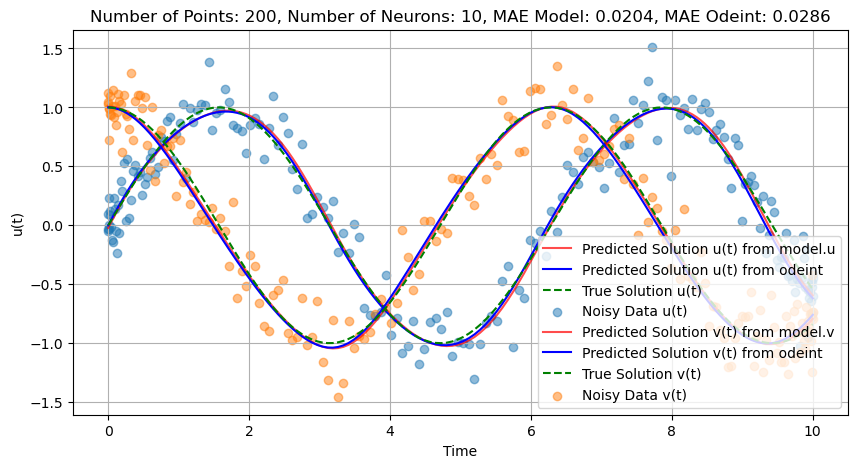

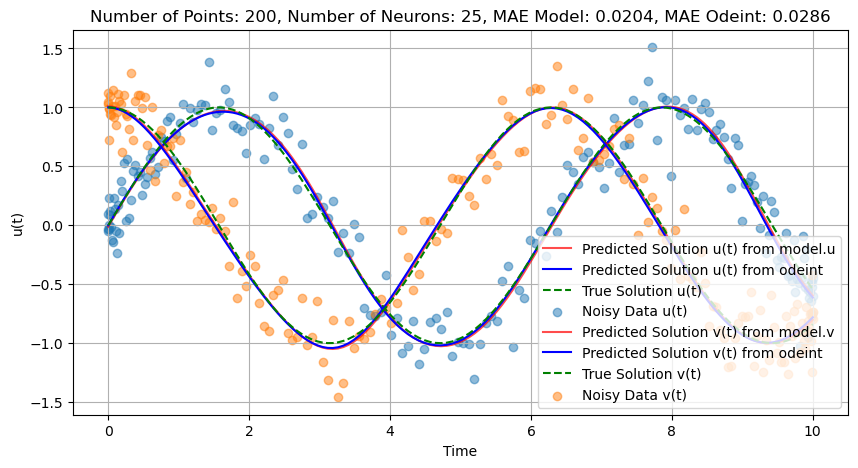

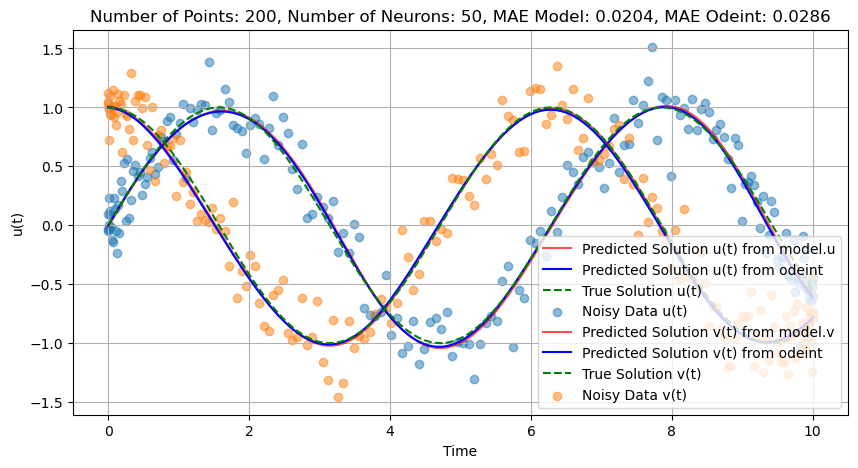

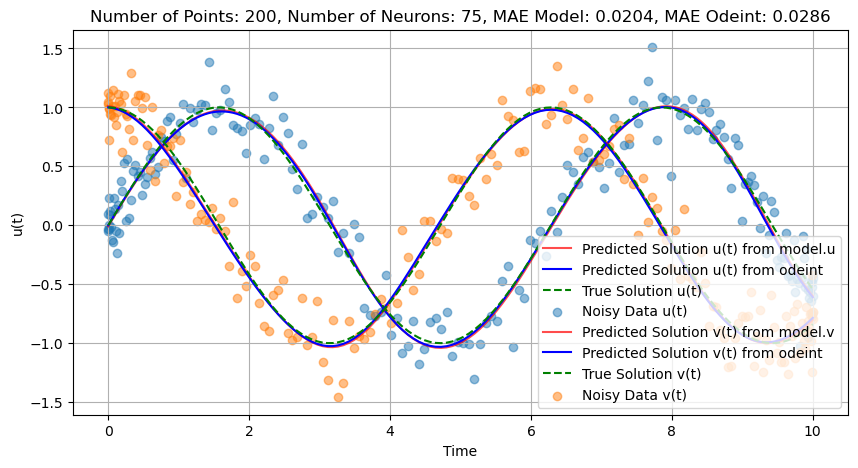

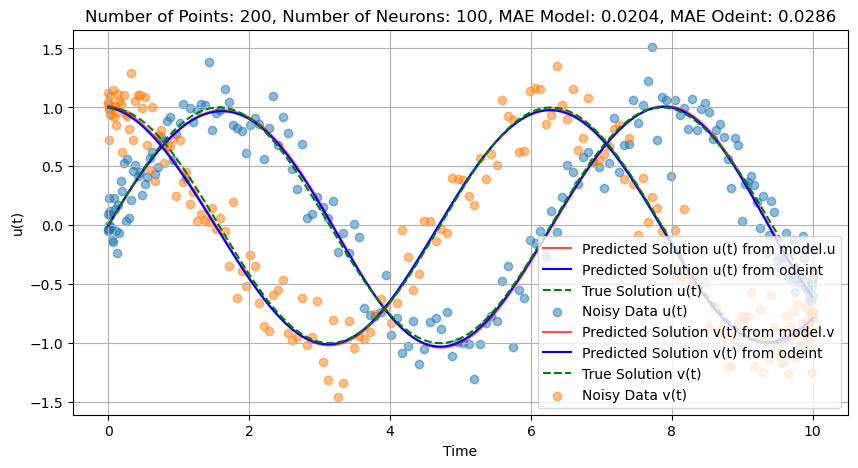

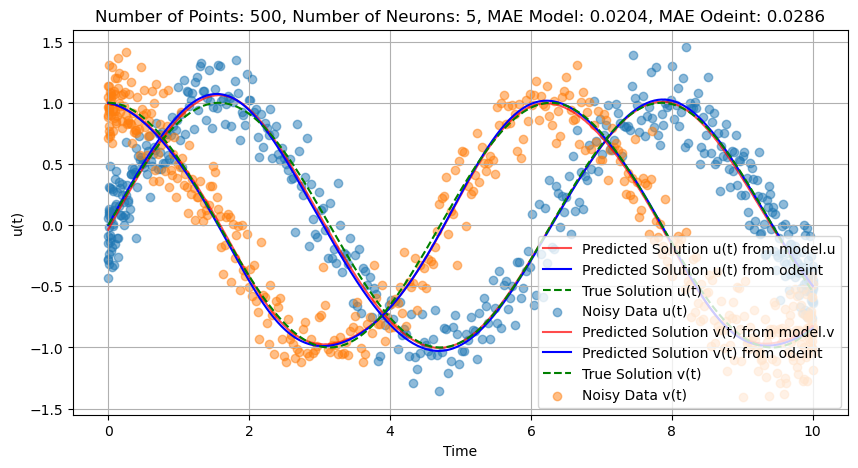

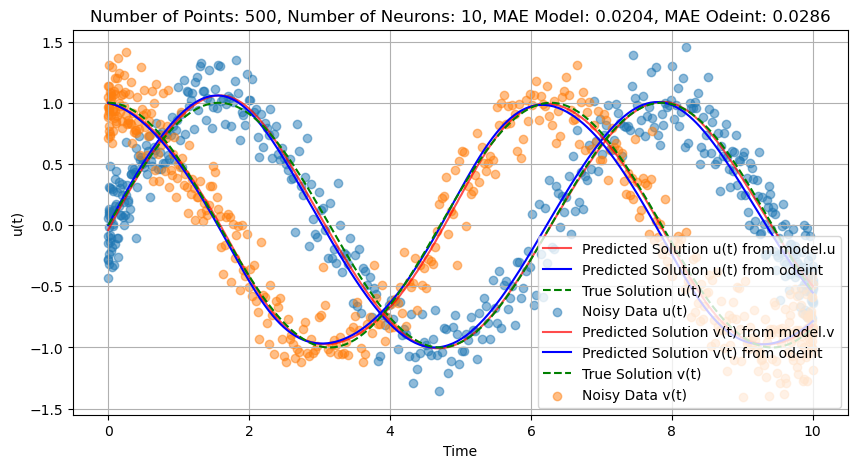

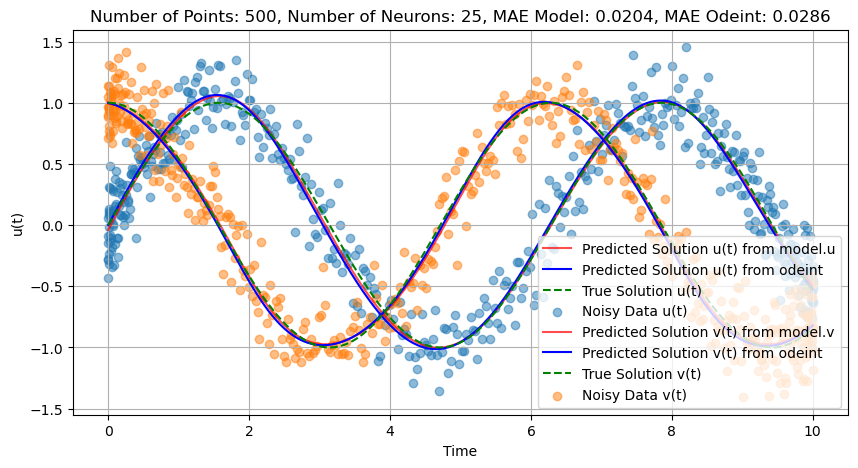

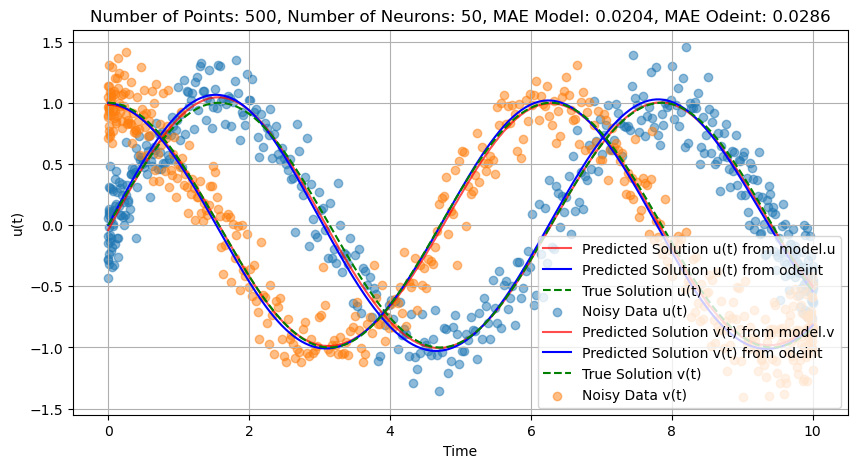

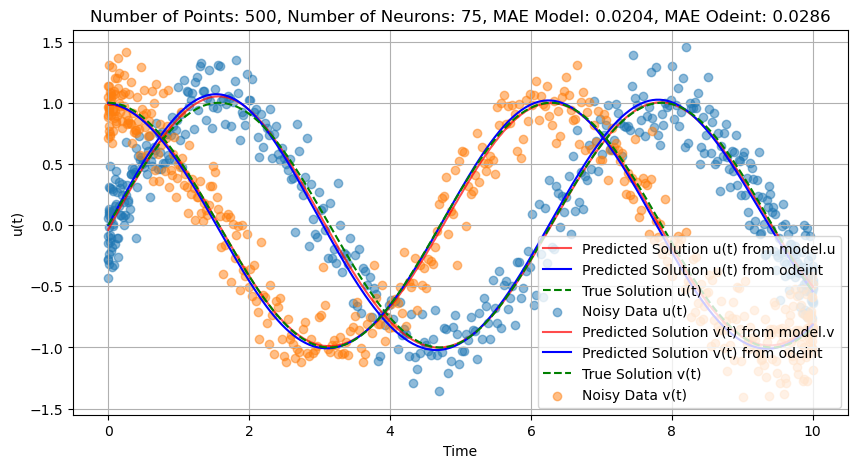

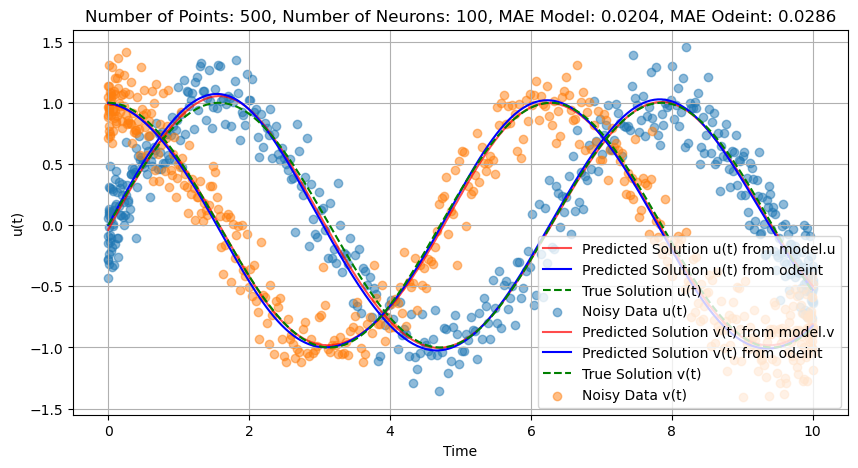

In [36]:
for n_pt in n_pts_li:
    for n_neurons in n_neurons_li:
        result = results[str(n_pt) + "_" + str(n_neurons)]
        t, y, y_noisy = result["t"], result["y"], result["y_noisy"]
        mae_model, mae_odeint = round(mae_model, 4), round(mae_odeint, 4)
        u_model, v_model, u_odeint, v_odeint = result["u_model"], result["v_model"], result["u_odeint"], result["v_odeint"]
        plt.figure(figsize=(10, 5))
        plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
        plt.plot(t, u_odeint, 'b', label='Predicted Solution u(t) from odeint')
        plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
        plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

        plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
        plt.plot(t, v_odeint, 'b', label='Predicted Solution v(t) from odeint')
        plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
        plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
        plt.xlabel('Time')
        plt.ylabel('u(t)')
        plt.title('Number of Points: ' + str(n_pt) + ', Number of Neurons: ' + str(n_neurons) + ', MAE Model: ' + str(mae_model) + ', MAE Odeint: ' + str(mae_odeint))
        plt.legend(loc ="lower right")
        plt.grid(True)
        plt.show()